In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

precipitation trends in Mayrland

http://marylandclimateandweather.weathertogether.net/maryland-statewide-average-precipitation-1895-2017/

Guidelines for the project

https://mde.maryland.gov/programs/Water/TMDL/TMDLImplementation/Pages/overview.aspx

Will Maryland meet the projects set for itself by 2025?

Show how much each sector has decreased over time 

Here we are cleaning the data set in order to do analysis later. We removed Land-River Segment and FIP because they are not necessary for our analysis (should we explain why they are not necessary?). Then we use the pandas features melt to change the format of the data from horizontal to verticle.


In [4]:
def sub_list(original, search): #takes a list and returns elements from the list that contain the search parameter
    return [i for i in original if search in i]

def unwanted_list(full,wanted): # Sets: all bodies - desired bodies = unwanted bodies
    return list(set(full)-set(wanted))

def scale_col(column):#normalizes the values of the column passed in
    return (column - column.mean()) / column.std()

def ave_lin_reg_plot(frame, labels, title):#used for west vs east bay plots as they were repetative
    ave_frame =  frame.groupby(['Major Basin','Year']).mean().reset_index()
    basins = ave_frame['Major Basin'].unique()
    for basin in basins:
        data = ave_frame[ave_frame['Major Basin'] == basin]
        X = data.Year[1:-2].astype(int)
        y = data["Total lbs."][1:-2]
        sns.regplot(x=X, y=y)
    plt.legend(labels=labels, loc = 2, bbox_to_anchor = (1,1))
    plt.title(title)
    
def pollution_cleaning(filename):
    df = pd.read_csv(filename)
    df.drop(['Land-River Segment', 'FIPS'], axis=1, inplace=True)

    temp_dict = {}
    for column in df.columns[4:]:
        temp_dict[column] = re.findall("\d{4}", column)[0]

    df.rename(columns=temp_dict, inplace = True)
    df = pd.melt(df,id_vars=['County','Tributary Basin','Major Basin','Source Sector'], \
                          var_name='Year', value_name='Total lbs.')

    unwanted = sub_list(df['Major Basin'].unique() ,"Basin")
    df = df.set_index("Major Basin")
    df.drop(unwanted,axis=0,inplace=True)
    df = df.reset_index()

    wanted = sub_list(df['Tributary Basin'].unique(),"Shore")
    all_bodies = df['Tributary Basin'].unique()
    df = df.set_index("Tributary Basin")
    df.drop( unwanted_list( all_bodies, wanted) , axis=0, inplace=True)
    df = df.reset_index()
    
    return df

In [5]:
nitrogen_df = pollution_cleaning('Nitrogen_loads.csv')
phosphorus_df = pollution_cleaning('Phosphorus_loads.csv')
soil_df = pollution_cleaning('Sediment_loads.csv')

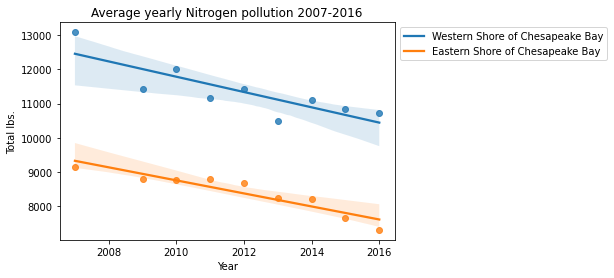

In [6]:
ave_lin_reg_plot(nitrogen_df,nitrogen_df['Major Basin'].unique(),"Average yearly Nitrogen pollution 2007-2016")

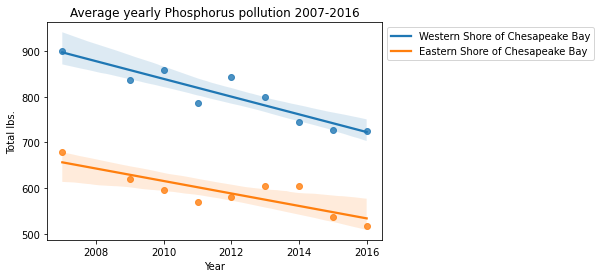

In [7]:
ave_lin_reg_plot(phosphorus_df,phosphorus_df['Major Basin'].unique(),"Average yearly Phosphorus pollution 2007-2016")

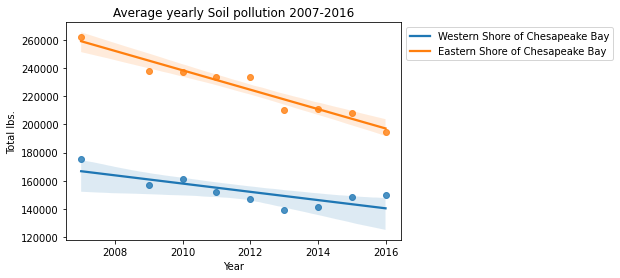

In [8]:
ave_lin_reg_plot(soil_df,soil_df['Major Basin'].unique(),"Average yearly Soil pollution 2007-2016")

Ignore results for 2017 and 2025 because those were predictions that the reseachers made. The only measured values are 2007-2016

Text(0, 0.5, 'Total lbs.')

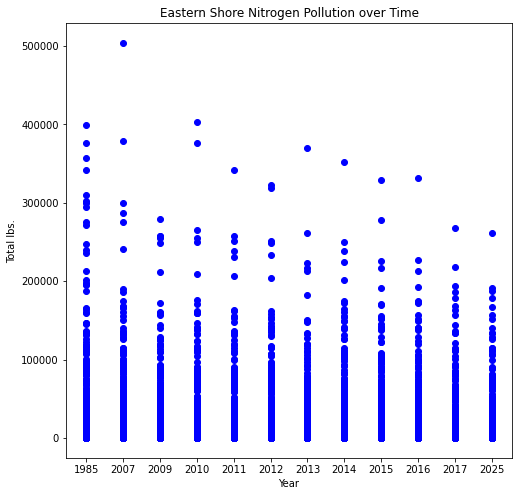

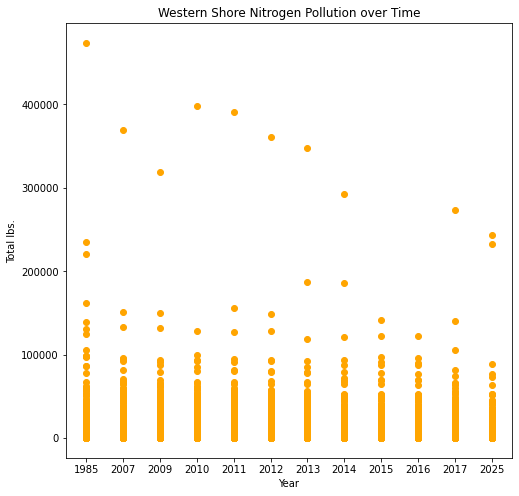

In [9]:
fig = plt.figure(figsize = (8, 8))
eastern_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Eastern Shore of Chesapeake Bay']
western_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Western Shore of Chesapeake Bay']
plt.scatter(eastern_shore['Year'], eastern_shore['Total lbs.'], c = "blue")
plt.xlabel('Year')
plt.ylabel('Total lbs.')
plt.title("Eastern Shore Nitrogen Pollution over Time")
fig = plt.figure(figsize = (8, 8))
plt.scatter(western_shore['Year'], western_shore['Total lbs.'], c = "orange")
plt.title("Western Shore Nitrogen Pollution over Time")
plt.xlabel('Year')
plt.ylabel('Total lbs.')

Here it seems that the data for nitrogen pollution is trending downwards, but it is still a bit hard to tell because the points are mainly grouped together towards the bottom of the plot. The strip plot below shows that the concentration lies mainly at the bottom and that it takes up a lot of space.

Text(0.5, 1.0, 'Western Shore Total Pounds of Nitrogen per Year')

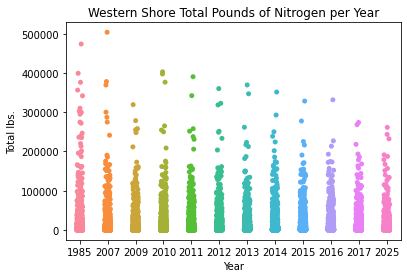

In [10]:
sns.stripplot(data = eastern_shore, x = eastern_shore['Year'], y = eastern_shore['Total lbs.'])
plt.title("Eastern Shore Total Pounds of Nitrogen per Year")

sns.stripplot(data = western_shore, x = western_shore['Year'], y = western_shore['Total lbs.'])
plt.title("Western Shore Total Pounds of Nitrogen per Year")

To make it easier to see the data, we took averages of each year and plotted them. This method is affected by outliers but due to the amount of points at the lower end of Total lbs we thought that the distribution would still be good. The regression lines we have here show that there is in fact a negative correlation between nitrogen pollution and time over the last decade or so. This is because there has been an effort in the bay to cleanup pollution.

Text(0.5, 1.0, 'Western Shore Phosphorus Pollution over time.')

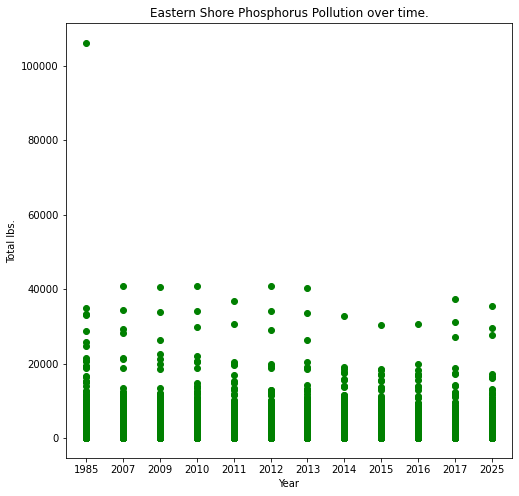

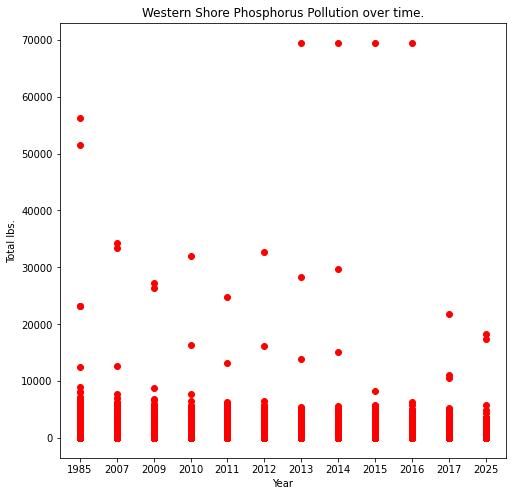

In [11]:
eastern_phosphorus = phosphorus_df[phosphorus_df['Major Basin'] == "Eastern Shore of Chesapeake Bay"]
western_phosphorus = phosphorus_df[phosphorus_df['Major Basin'] == "Western Shore of Chesapeake Bay"]

fig = plt.figure(figsize = (8, 8))
plt.scatter(eastern_phosphorus['Year'], eastern_phosphorus['Total lbs.'], c = "green")
plt.xlabel("Year")
plt.ylabel("Total lbs.")
plt.title("Eastern Shore Phosphorus Pollution over time.")

fig = plt.figure(figsize = (8, 8))
plt.scatter(western_phosphorus['Year'], western_phosphorus['Total lbs.'], c = "red")
plt.xlabel("Year")
plt.ylabel("Total lbs.")
plt.title("Western Shore Phosphorus Pollution over time.")

The reason that the eastern shore has more pollution is due to nitrogen in groundwater. This is evidenced here https://www.chesapeakebay.net/news/blog/excess_nitrogen_phosphorus_flow_from_eastern_shore_to_bay_waters

In [12]:
algae_df = pd.read_csv('LivingResourcesReportedStation.csv', low_memory =False, parse_dates=True)
desired = ['Prorocentrum minimum','Prorocentrum micans','Blue green sphere','Prorocentrum gracile']
all_alg = algae_df['LatinName'].unique()
# Sets: all bodies - desired bodies = unwanted bodies
unwanted = list(set(all_alg)-set(desired))

algae_df = algae_df.set_index("LatinName")
algae_df.drop(unwanted,axis=0,inplace=True)
algae_df = algae_df.reset_index()

algae_df = algae_df.rename(columns={"ReportingValue": "ReportingValue(L)"})
algae_df = algae_df.drop(['ReportingUnit','Parameter','SampleType','SampleNumber','TSN','NODCCode','SPECCode'], axis=1)

year = []
for date in algae_df.SampleDate:
    year.append(date[-4:])    
algae_df['Year'] = year
algae_df['Year'] = algae_df['Year'].astype(int)

https://www.cbf.org/how-we-save-the-bay/chesapeake-clean-water-blueprint/the-history-of-bay-cleanup-efforts.html
This link may explain why there is a general decrease in prorocentrum minimum over the years

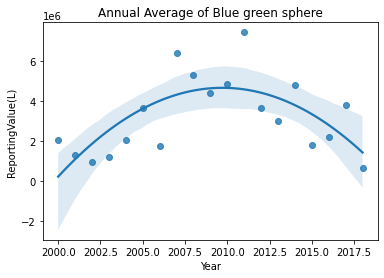

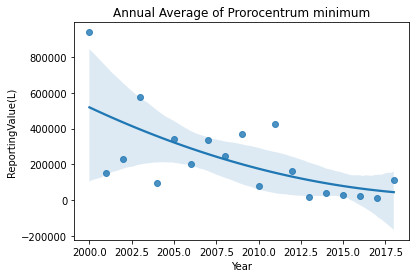

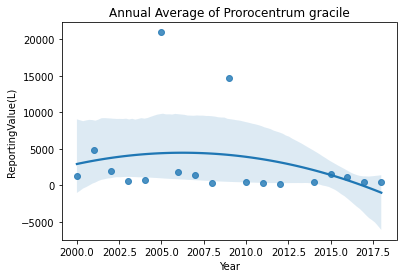

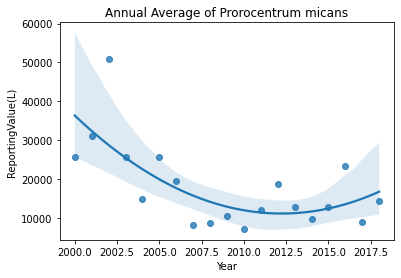

In [13]:
for name in algae_df.LatinName.unique():
    fig, ax = plt.subplots()
    temp = algae_df[algae_df['LatinName'] == name]
    temp = temp.groupby('Year').mean().reset_index()
    ax = sns.regplot(data = temp, order=2, x='Year', y='ReportingValue(L)',truncate = True)
    title = "Annual Average of "+name
    ax.set_title(title)

In [14]:
activites_df = pd.read_csv('Reduction_Activities.csv')
activites_df["Fiscal Year"] = list(range(2000,2015))

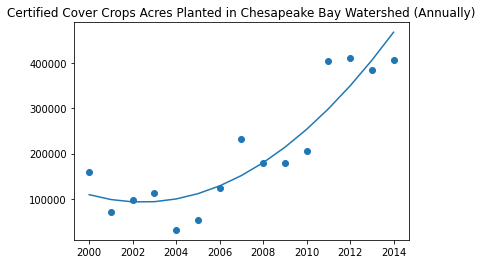

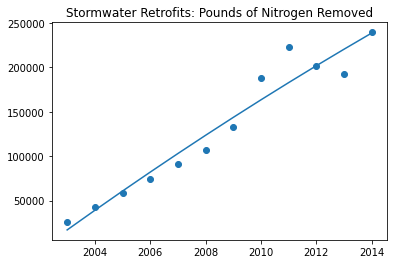

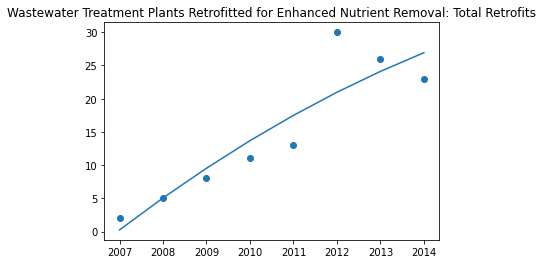

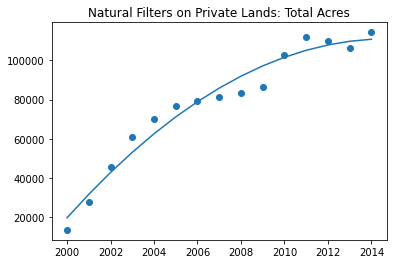

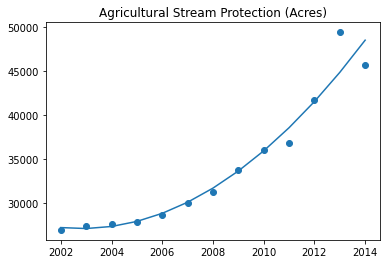

In [15]:
# from sklearn.metrics import mean_squared_error, r2_score

col_names = activites_df.columns
#each of the columns selected give the total amount of that activity for each year
temp = [1,2,5,8,11]

for i in temp:
    fig, ax = plt.subplots()
    
    activity = col_names[i] # gets the name for the selected pollution reduction activity

    #to remove NaN values in the list without removing from the dataframe
    #this is necessary because some of the activities started several years after the others
    #so there are several rows of NaN values that can not be used for some activities
    y = [i for i in activites_df[activity] if pd.notna(i)]
    x = activites_df['Fiscal Year'][-len(y):].array.reshape(-1, 1)

    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    plt.scatter(x, y)
    plt.plot(x, y_poly_pred)
    ax.set_title(activity)
    plt.show()

In [16]:
prorocentrum_minimum = algae_df[algae_df['LatinName'] == 'Prorocentrum minimum']
ave_N['Year'] = pd.to_numeric(ave_N['Year'])
joined = ave_N.set_index('Year').join(prorocentrum_minimum.set_index('Year'))
joined = joined.groupby('Year').mean().reset_index()
fig = plt.figure(figsize = (6, 6))
plt.scatter(joined['Total lbs.'], joined['ReportingValue(L)'])
plt.xlabel('Avg. Total lbs. of Nitrogen Pollution')
plt.ylabel('Avg. Prorocentrum Minimum Concentration in Liters')
plt.title('Total lbs of Nitrogen Pollution vs. Prorocentrum Minimum Concentration')

NameError: name 'ave_N' is not defined

As can be seen above, the algae concentration in Liters of the prorocentrum minimum species in the Chesapeake bay increases as as the average amount of nitrogen pollution increases. Although not shown here, the higher concentration values are from earlier years and the lower values are from later years. 

In [17]:
#importing, fixing, adding to, and cleaning annual rain data for maryland
average_rainfall = pd.read_csv('18-pcp-18-4-2000-2021.csv')
average_rainfall.rename(columns={" Precipitation": "Annual Precipitation (in.)"}, inplace = True)
average_rainfall = average_rainfall.drop([0,1,2], axis=0).reset_index()
average_rainfall.drop(['index',average_rainfall.columns[3]], axis=1,inplace = True)

year = []
#format for the date values is YYYYMM
for i in average_rainfall.Maryland:
    year.append(i[0:4])
    
average_rainfall["Year"] = year
average_rainfall = average_rainfall.astype(float)
average_rainfall['Scaled_Rain'] = scale_col(average_rainfall['Annual Precipitation (in.)'])

In [19]:
pm_df = algae_df[algae_df['LatinName'] == 'Prorocentrum minimum'].groupby('Year').mean().reset_index()
pm_df['Scaled_PM'] = scale_col(pm_df['ReportingValue(L)'])

In [20]:
nitrogen_2 = pd.read_csv('Updated_Nitrogen_90_19.csv')
nitrogen_2.rename(columns={'Water Year (WY)': 'Year'}, inplace = True)
nitrogen_2['Scaled_N'] = scale_col(nitrogen_2['Rounded Total (x10^6 lbs/yr)'])

phosphorus_2 = pd.read_csv('Updated_phosphorus_90_19.csv')
phosphorus_2.rename(columns={'Water Year (WY)': 'Year'}, inplace = True)
phosphorus_2['Scaled_P'] = scale_col(phosphorus_2['Rounded Total (x10^6 lbs/yr)'])

soil_df = pd.read_csv('Updated_Soil_90_19.csv')
soil_df.rename(columns={'Water Year (WY)': 'Year'}, inplace = True)
soil_df['Scaled_S'] = scale_col(soil_df['Rounded Total (x10^6 lbs/yr)'])

In [21]:
dissolved_o2 = pd.read_csv('Dissolved_oxygen.csv', low_memory =False, parse_dates=True)

wanted_number = [8,10,11,12,13,14,19,27,28]
wanted_name = []
for col in wanted_number:
    wanted_name.append(dissolved_o2.columns[col])
    
dissolved_o2.drop( unwanted_list( dissolved_o2.columns, wanted_name) ,axis = 1,inplace = True)

dissolved_o2.dropna(inplace=True)

year = []
for i in dissolved_o2.SampleDate:
    year.append(i[-4:])
dissolved_o2['Year'] = year

dissolved_o2 = dissolved_o2.rename({'MeasureValue':'MeasureValue (MG/L)'})

Text(0.5, 1.0, 'Annual Average Dissolved O2 in MG/L')

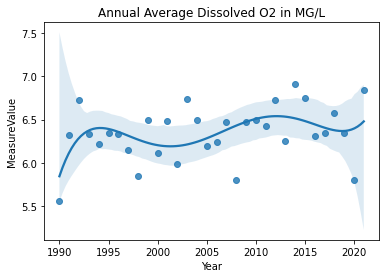

In [22]:
data =  dissolved_o2.groupby(['Year']).mean().reset_index()
data['Scaled_02'] = scale_col(data.MeasureValue)
data = data.astype(float)
X = data.Year.astype(int)
y = data["MeasureValue"]
sns.regplot(x=X, y=y, order = 5)
plt.title('Annual Average Dissolved O2 in MG/L')

<AxesSubplot:xlabel='Year'>

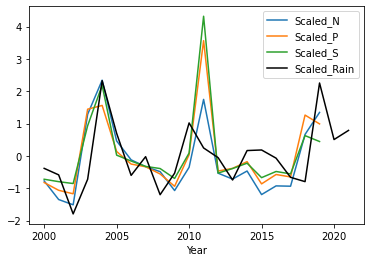

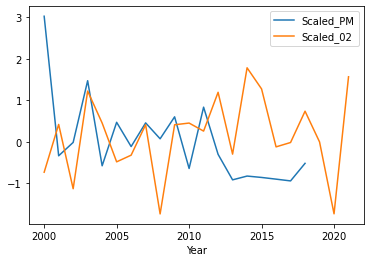

In [23]:
ax = nitrogen_2[15:].plot(x='Year', y='Scaled_N')
ax = phosphorus_2[15:].plot(ax =ax, x='Year', y='Scaled_P')
ax = soil_df[15:].plot(ax =ax, x='Year', y='Scaled_S')
average_rainfall.plot(ax =ax,x='Year', y='Scaled_Rain', color = "black")

ax = pm_df.plot(x='Year', y='Scaled_PM')
# nitrogen_2[15:].plot(ax =ax, x='Year', y='Scaled_N')
data[10:].plot(ax =ax, x='Year', y='Scaled_02')